In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
import tensorflow.keras.preprocessing.sequence as sequence
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13920691353295127216
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14319988630446084737
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7441530880
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14960164321369080558
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1835148086764494031
physical_device_desc: "device: XLA_GPU device"
]


In [4]:
from keras import backend
backend.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0817 06:37:58.441687 140261535074048 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0817 06:37:58.442496 140261535074048 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0817 06:37:58.443126 140261535074048 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0817 06:37:58.450799 140261535074048 deprecation_wrapper.py:119] From /home/mdogan/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use 

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
#read in the csvs obtained from 03_tags_clustering
# chem = pd.read_csv("../data/equation/chemistry_post_eq_tag_id.csv", lineterminator='\n')
chem = pd.read_csv("../data/equation/chemistry_post_eq_tag_id_3.csv", lineterminator='\n')
# physics = pd.read_csv("../data/equation/physics_post_eq_tag_id.csv", lineterminator='\n')
physics = pd.read_csv("../data/equation/physics_post_eq_tag_id_3.csv", lineterminator='\n')
# bio = pd.read_csv("../data/equation/biology_post_eq_tag_id.csv", lineterminator='\n')

In [6]:
# df = pd.concat([chem, physics, bio], ignore_index=True)
df = pd.concat([chem, physics], ignore_index=True)
df.head()

,Equation,Label,Cluster_label,Id,Tags
0,\mathrm{NaCl},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
1,\mathrm{Cl},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
2,\mathrm{Cl^-},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
3,\mathrm{Na},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
4,\mathrm{Na^+},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...


In [7]:
df = df[df['Cluster_label'] != 'physics-everything-else']

In [8]:
# df = df[df.apply(lambda row: len(row.Equation) > 3, axis = 1)]

In [9]:
df.shape[0]

397812

In [10]:
len(df[df['Equation'].isnull()])

107

In [11]:
df.dropna(subset = ['Equation'], inplace = True)

In [12]:
df.shape[0]

397705

In [13]:
df.rename(columns={"Label": "Source"}, inplace = True)

In [14]:
def split_data(df, frac=0.1):
    """
    Split the data by the post id.
    Equations from the same post will be in the same set.
    """
    split_by = df.Id
    post_ids = df.Id.unique()
    N = len(post_ids)
    
    test_posts = np.random.choice(post_ids, int(N * frac))
    n_test = len(test_posts)
    test_condition = df.Id.isin(test_posts)
    return df[~test_condition], df[test_condition]

In [15]:
np.random.seed(1)
print('Null Data: ', df.Equation.isnull().sum())
df.dropna(subset=['Equation'], inplace=True)
df = df.drop_duplicates(subset=['Equation', 'Source', 'Cluster_label'])
train_df, test_df = split_data(df, 0.1)
train_df, val_df = split_data(train_df, 0.1)

print(f'Training rows: {train_df.shape[0]}')
print(f'Val rows: {val_df.shape[0]}')
print(f'Test rows: {test_df.shape[0]}')

Null Data:  0
Training rows: 165482
Val rows: 17313
Test rows: 19321


In [16]:
train_df.head()

,Equation,Source,Cluster_label,Id,Tags
0,\mathrm{NaCl},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
1,\mathrm{Cl},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
2,\mathrm{Cl^-},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
3,\mathrm{Na},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...
4,\mathrm{Na^+},chemistry,chemistry,2,<ions><crystal-structure><ionic-compounds><sol...


In [17]:
class Tokenizer:
    """Convert chars to ints"""
    def __init__(self):
        self.UNK = '<UNK>'  # Unknown
        self.BOS = '<BOS>'  # Begin of string
        self.EOS = '<EOS>'  # End of string
        self.PAD = '<PAD>'  # Padding
        self.char_to_idx = dict()
        self.idx_to_char = dict()
        self.vocab = []
        
        self.specials = [self.PAD, self.BOS, self.EOS, self.UNK]
        for c in self.specials: self.add(c)
        
    
    def __getitem__(self, c: str):
        try:
            return self.char_to_idx[c]
        except KeyError:
            return self.char_to_idx[self.UNK]
    
    def fit(self, sequences):
        """Create the vocab from a sequence of strings"""
        chars = set.union(*map(set, sequences))
        for char in chars: self.add(char)

    def add(self, c: str):
        """Add the character if its not in the vocab, else do nothing"""
        if self.char_to_idx.get(c) is None:
            self.char_to_idx[c] = len(self.vocab)
            self.idx_to_char[len(self.vocab)] = c
            self.vocab.append(c)
        return len(self.vocab)

    
def encode_sequence(seq, tokenizer):
    return [tokenizer[tokenizer.BOS]] + [tokenizer[c] for c in seq] + [tokenizer[tokenizer.EOS]]

In [18]:
tokenizer = Tokenizer()
tokenizer.fit(train_df.Equation)

# convert string to list of int
train_df['seq'] = train_df.Equation.apply(encode_sequence, args=(tokenizer,))
val_df['seq'] = val_df.Equation.apply(encode_sequence, args=(tokenizer,))
test_df['seq'] = test_df.Equation.apply(encode_sequence, args=(tokenizer,))

train_df['length'] = train_df.seq.apply(len)
val_df['length'] = val_df.seq.apply(len)
test_df['length'] = test_df.seq.apply(len)

labels = train_df.Cluster_label.unique()
label_map = {label: i for i, label in enumerate(labels)}

train_df['Label'] = train_df.Cluster_label.map(label_map)
val_df['Label'] = val_df.Cluster_label.map(label_map)
test_df['Label'] = test_df.Cluster_label.map(label_map)


/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [19]:
encode_sequence('1234', tokenizer)

[1, 18, 62, 132, 180, 2]

In [20]:
tokenizer['4']

180

In [21]:
len(tokenizer.vocab)

292

In [22]:
label_map

{'chemistry': 0,
 'physics-homework-exercises': 1,
 'physics-quantum-mechanics': 2,
 'physics-field-theory': 3}

In [23]:
train_df.sample(10)

,Equation,Source,Cluster_label,Id,Tags,seq,length,Label
6695,i = 2,chemistry,chemistry,5065,NaN,"[1, 57, 84, 202, 84, 62, 2]",7,0
225979,t = -2 \int^{x}_{x_0} \frac{dx}{ln|x|},physics,physics-homework-exercises,45715,<homework-and-exercises><newtonian-mechanics><...,"[1, 31, 84, 202, 84, 15, 62, 84, 46, 57, 4, 31...",40,1
296783,imply,physics,physics-quantum-mechanics,129037,<quantum-mechanics><operators><momentum><hilbe...,"[1, 84, 57, 108, 204, 139, 167, 84, 2]",9,2
611846,k=\frac {\sqrt {2mE}}{\hbar},physics,physics-quantum-mechanics,458203,<quantum-mechanics><potential><schroedinger-eq...,"[1, 194, 202, 46, 157, 181, 61, 195, 84, 170, ...",30,2
48013,\ce{2H2O_{(aq)} -&gt;2H2_{(g)} +O2_{(g)}}~~~~\...,chemistry,chemistry,29475,NaN,"[1, 46, 195, 155, 170, 62, 55, 62, 107, 102, 1...",77,0
364448,for a general,physics,physics-homework-exercises,209545,<homework-and-exercises><special-relativity><t...,"[1, 84, 157, 162, 181, 84, 61, 84, 258, 155, 4...",17,1
31498,d\rho,chemistry,chemistry,18418,NaN,"[1, 161, 46, 181, 227, 162, 2]",7,0
66211,AM^.,chemistry,chemistry,38936,NaN,"[1, 274, 7, 11, 97, 2]",6,0
485324,\phi =0,physics,physics-quantum-mechanics,334041,<quantum-mechanics><electromagnetism><gauge-in...,"[1, 84, 46, 204, 227, 57, 84, 202, 148, 2]",10,2
159993,\ce{N2(g) + 3H2 (g) -&gt; 2NH3(g)},chemistry,chemistry,91607,<equilibrium><units>,"[1, 46, 195, 155, 170, 53, 62, 219, 258, 66, 8...",36,0


In [24]:
class DataGenerator(utils.Sequence):
    def __init__(self, df, batch_size: int = 32, shuffle: bool = False, weight: bool = False, n_class: int = 3):
        self.df = df
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.weight = weight
        self.n_class = n_class
        self.class_weight =  self.compute_class_weight(self.n_class) if self.weight else np.ones((self.n_class,))
        
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            

    def get_data_at_index(self, batch_idx):
        offset = self.batch_size * batch_idx
        return self.df.iloc[offset: offset+self.batch_size]
    
    def __getitem__(self, batch_idx: int):
        batch = self.get_data_at_index(batch_idx)
        if self.shuffle:
            batch = batch.sample(frac=1)

        X = sequence.pad_sequences(
            batch.seq,
            maxlen=min( max(batch.length), 32),
            truncating='post',
        )
        Y = batch.Label.values
        w = np.array([self.class_weight[label] for label in Y])
        return X, Y, w
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1)
            
    def __len__(self):
        return int(np.ceil( self.df.shape[0] / self.batch_size ))
    
    def compute_class_weight(self, n_classes):
        n_samples = self.df.shape[0]
        return n_samples / (n_classes * np.bincount(self.df.Label.values))


In [25]:
class Mask(layers.Layer):
    def call(self, inputs):
        value = tf.cast(0, dtype=inputs.dtype)
        is_zero = tf.equal(inputs, value)
        return tf.cast(tf.logical_not(is_zero), tf.float32)

        
class ApplyMask(layers.Layer):
    def call(self, inputs):
        data, mask = inputs
        mask = tf.expand_dims(mask, axis=-1)  # (N, T, 1)
        return tf.multiply(data, mask)

In [26]:
def clf_model(tokenizer, emb, n_kernels, kernel_width, n_class):
    
    # define layers
    input = layers.Input(batch_shape=(None, None))  # (N, T)
    embedding_layer = layers.Embedding(len(tokenizer.vocab), emb, mask_zero=False, name='embedding')  # (N, T, emb)
    mask_layer = Mask(name='mask')  # (N, T)
    conv_layer = layers.Conv1D(
        n_kernels, kernel_width, 
        activation='tanh',
        kernel_initializer='he_normal',
        padding='same',
        name='conv'
    )  # (N, T, n_kernels), selects 3-grams
    apply_mask_layer = ApplyMask(name='apply_mask')  # (N, T, n_kernels), zero the timesteps that were padding
    rnn_layer = layers.LSTM(n_kernels, name='rnn') # (N, e)
    softmax_layer = layers.Dense(n_class, activation='softmax', name='output')
    
    # call layers
    embedding = embedding_layer(input)
    mask = mask_layer(input)
    conv = conv_layer(embedding)
    conv = apply_mask_layer([conv, mask])
    encoded = rnn_layer(conv)
    output = softmax_layer(encoded)
    model = models.Model(input, output)
    return model
    
def compile_model(model):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['sparse_categorical_accuracy']
    )


In [21]:
# ensure balanced classes
# N_train = train_df.groupby('source').count().values.min()
# N_val = val_df.groupby('source').count().values.min()

# small_df = pd.concat([train_df[train_df.label==l].sample(N_train, replace=False) for l in range(3)])
# small_val_df = pd.concat([val_df[val_df.label==l].sample(N_val, replace=False) for l in range(3)])


# model3 (only equations with an equal sign): clustersize = 4, batch_size = 1024, emb = 32, n_kernels = 128, kernel_width = 3, epochs = 16

In [27]:
batch_size = 1024
n_class = 4
train_dg = DataGenerator(train_df, batch_size=batch_size, shuffle=True, weight=True, n_class = n_class)
val_dg = DataGenerator(val_df, batch_size=batch_size, shuffle=False, weight=False, n_class = n_class)

In [28]:
emb = 32
n_kernels = 128
kernel_width = 3

In [29]:
model = clf_model(tokenizer, emb, n_kernels, kernel_width, n_class)  # initialize the weights
compile_model(model)  # set the loss fn and optimizer
print(model.summary())  # check the number of parameters


W0817 06:40:33.939080 140261535074048 deprecation.py:506] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0817 06:40:33.941843 140261535074048 deprecation.py:506] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 32)     9344        input_1[0][0]                    
__________________________________________________________________________________________________
conv (Conv1D)                   (None, None, 128)    12416       embedding[0][0]                  
__________________________________________________________________________________________________
mask (Mask)                     (None, None)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [30]:
model.save('../result/model/model4_cluster4_epoch32.h5')

In [31]:
history = model.fit_generator(
    train_dg,
    validation_data=val_dg,
    epochs=32,
    workers=4,
    use_multiprocessing=True
)

Epoch 1/32


W0817 06:40:58.477077 140261535074048 deprecation.py:323] From /home/mdogan/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


162/162 [==============================] - 12s 75ms/step - loss: 1.1157 - sparse_categorical_accuracy: 0.5215 - val_loss: 0.9896 - val_sparse_categorical_accuracy: 0.5699
Epoch 2/32
162/162 [==============================] - 9s 53ms/step - loss: 1.0044 - sparse_categorical_accuracy: 0.5858 - val_loss: 0.9400 - val_sparse_categorical_accuracy: 0.5916
Epoch 3/32
162/162 [==============================] - 9s 53ms/step - loss: 0.9636 - sparse_categorical_accuracy: 0.6060 - val_loss: 0.9268 - val_sparse_categorical_accuracy: 0.5952
Epoch 4/32
162/162 [==============================] - 9s 53ms/step - loss: 0.9297 - sparse_categorical_accuracy: 0.6227 - val_loss: 0.8780 - val_sparse_categorical_accuracy: 0.6188
Epoch 5/32
162/162 [==============================] - 9s 53ms/step - loss: 0.9063 - sparse_categorical_accuracy: 0.6349 - val_loss: 0.8720 - val_sparse_categorical_accuracy: 0.6228
Epoch 6/32
162/162 [==============================] - 9s 53ms/step - loss: 0.8876 - sparse_categorical_ac

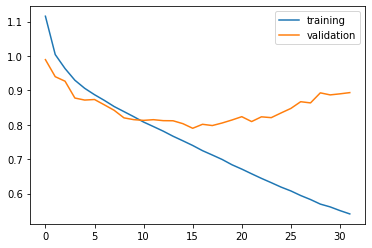

In [32]:
%matplotlib inline

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

name = "model4_cluster4_epoch32_1"
plt.savefig('../result/loss/' + name + '.png', dpi=200)

plt.show()

# Evaluation

## evaluation tools

In [33]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

%matplotlib notebook

def plot_confusion_matrix(y_true, y_pred, classes, name,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    plt.savefig('../result/confusion_matrix/' + name + '.png')
    return ax

In [34]:
def predict_on_df(model, df, batch_size, n_class):
    dg = DataGenerator(df, batch_size=batch_size, shuffle=False, weight = False, n_class = n_class)
    yhat = model.predict_generator(dg)
    pred_index = yhat.argmax(axis=1)
    pred_conf = yhat.max(axis=1)
    df['pred_index'] = pred_index
    df['pred_label'] = df.pred_index.apply(lambda x: list(label_map.keys())[x])
    df['pred_conf'] = pred_conf
    df['match'] = df['pred_index'] == df['Label']
    return df


def display_top_losses(prediction_df, k: int = 10):
    wrong_condition = ~prediction_df.match
    wrong_df = prediction_df[wrong_condition]
    return wrong_df.sort_values('pred_conf', ascending=False).iloc[0:k][['Equation', 'pred_label', 'Cluster_label', 'pred_index', 'Label', 'pred_conf']]
    
def predict_from_str(equation, model, tokenizer):
    X = np.array([encode_sequence(equation, tokenizer)])
    yhat = model.predict(X)
    pred_index = yhat.argmax()
    label = [label for label, i in label_map.items() if i==pred_index][0]
    return {
        'yhat': yhat.tolist(),
        'pred_index': pred_index,
        'label': label
           }

## evaluate

In [35]:
batch_size = 1024
n_class = 4
predictions = predict_on_df(model, test_df, batch_size, n_class)

/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mdogan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [36]:
%matplotlib inline

In [37]:
predictions[predictions.apply(lambda row: row.Label == row.pred_index, axis = 1)].shape[0]/(predictions.shape[0])

0.6728430205475907

In [38]:
predictions.head()

,Equation,Source,Cluster_label,Id,Tags,seq,length,Label,pred_index,pred_label,pred_conf,match
90,G_\text{liquid} - G_\text{crystal} = H_\text{...,chemistry,chemistry,56,NaN,"[1, 84, 126, 102, 46, 31, 155, 214, 31, 170, 1...",118,0,0,chemistry,0.999687,True
91,\Delta G = \Delta H - T \Delta S,chemistry,chemistry,56,NaN,"[1, 84, 46, 127, 155, 139, 31, 61, 84, 126, 84...",36,0,0,chemistry,0.996406,True
93,\Delta H &lt; T \Delta S,chemistry,chemistry,56,NaN,"[1, 46, 127, 155, 139, 31, 61, 84, 55, 84, 191...",26,0,0,chemistry,0.990958,True
94,q_+,chemistry,chemistry,56,NaN,"[1, 249, 102, 17, 2]",5,0,3,physics-field-theory,0.650287,False
95,q_-,chemistry,chemistry,56,NaN,"[1, 249, 102, 15, 2]",5,0,3,physics-field-theory,0.469763,False


In [39]:
predictions.groupby(['Label'])['Label'].count()

Label
0    7997
1    4825
2    4085
3    2414
Name: Label, dtype: int64

Confusion matrix, without normalization
[[6026  897  628  446]
 [ 352 3106  771  596]
 [ 179  620 2588  698]
 [  82  433  619 1280]]


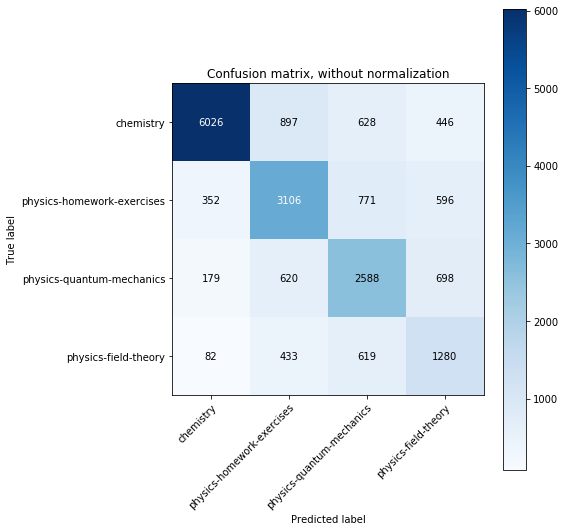

In [40]:
name = "model4_cluster4_epoch32_1"
plot_confusion_matrix(predictions.Label, predictions.pred_index, np.array(list(label_map.keys())), name)


Normalized confusion matrix
[[0.75353257 0.11216706 0.07852945 0.05577091]
 [0.07295337 0.64373057 0.15979275 0.12352332]
 [0.04381885 0.15177479 0.63353733 0.17086903]
 [0.03396852 0.17937034 0.25642088 0.53024027]]


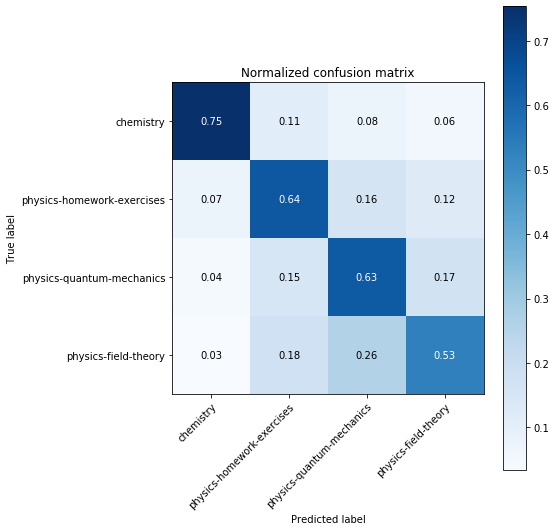

In [41]:
name = "model4_cluster4_epoch32_2"
plot_confusion_matrix(predictions.Label, predictions.pred_index, np.array(list(label_map.keys())), name, normalize=True)


In [42]:
predict_from_str('H\PSI = E\PSI', model, tokenizer)

{'yhat': [[0.9698496460914612,
   0.00042502552969381213,
   0.02669234573841095,
   0.003032986307516694]],
 'pred_index': 0,
 'label': 'chemistry'}

In [43]:
display_top_losses(predictions, 20)

,Equation,pred_label,Cluster_label,pred_index,Label,pred_conf
236720,1\text{p}_{\frac{3}{2}},chemistry,physics-homework-exercises,0,1,0.999769
532377,\sum_{\mathrm{all~forces}}W = \Delta K,chemistry,physics-homework-exercises,0,1,0.999608
453880,\mathbb{1}_{3 \times 3} - \begin{pmatrix} 0 \...,physics-field-theory,physics-homework-exercises,3,1,0.999598
384649,M^2 = \underline{k} + m^2,physics-field-theory,physics-homework-exercises,3,1,0.999577
408992,a_{Rk}^\dagger=a_{k_F+k}^\dagger,physics-field-theory,physics-quantum-mechanics,3,2,0.999327
453761,\mathcal{H}_{\text{Fermion}},physics-field-theory,physics-quantum-mechanics,3,2,0.999041
546398,"\psi(x,t) = f(kx-\omega t)",physics-quantum-mechanics,physics-homework-exercises,2,1,0.999024
325245,"[J_a,O^s_{\ell}] = O^s_m~[J_a^s]_{m\ell}, \tag...",physics-field-theory,physics-quantum-mechanics,3,2,0.998957
402954,"100\,\rm m/s",physics-homework-exercises,physics-quantum-mechanics,1,2,0.998910
195589,rate=k[A]..... (13.2),physics-field-theory,chemistry,3,0,0.998832
